<a href="https://colab.research.google.com/github/jsumbo/Group_2_Sentiment_Analysis_Project/blob/main/Final_Sentiment_Analysis_Group_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 📚 IMPORTS
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             roc_curve, auc)

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Citations
# Dataset: S. Shahane, “Twitter Sentiment Dataset,” Kaggle, Jan 2020.
# NLTK: Bird et al., “Natural Language Processing with Python,” O’Reilly, 2009.

nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Load and inspect data
df = pd.read_csv('Twitter_Data.csv', encoding='latin-1', header=None) # Read without header
df = df[[0, 5]].dropna() # Select columns by index (0 for category, 5 for text)
df.columns = ['category', 'clean_text'] # Rename columns
df = df[df.category.isin([0, 4])] # Keep only categories 0 and 4 (assuming 0 is negative and 4 is positive)
df['sentiment'] = df['category'].map({4: 1, 0: 0}) # Map 4 to 1 (positive) and 0 to 0 (negative)


print("Rows:", df.shape[0])
print(df['sentiment'].value_counts())

Rows: 1600000
sentiment
0    800000
1    800000
Name: count, dtype: int64


EDA

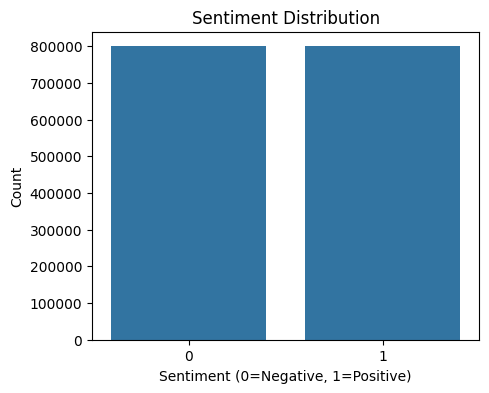

In [ ]:
# A) Class distribution
plt.figure(figsize=(5,4))
sns.countplot(x='sentiment', data=df)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment (0=Negative, 1=Positive)')
plt.ylabel('Count'); plt.show()

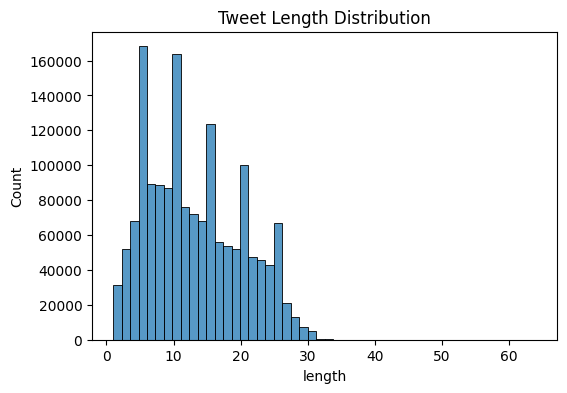

In [ ]:
# B) Tweet length histogram
df['length'] = df['clean_text'].str.split().apply(len)
plt.figure(figsize=(6,4))
sns.histplot(df['length'], bins=50)
plt.title('Tweet Length Distribution'); plt.show()

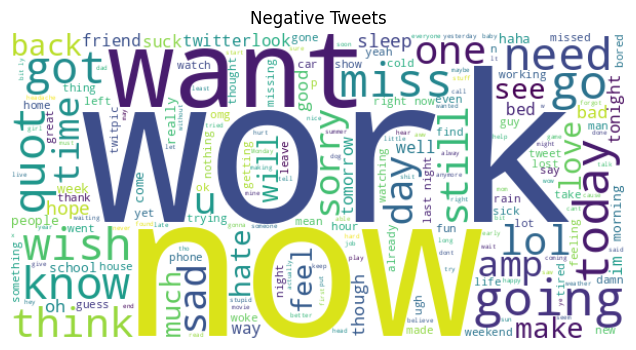

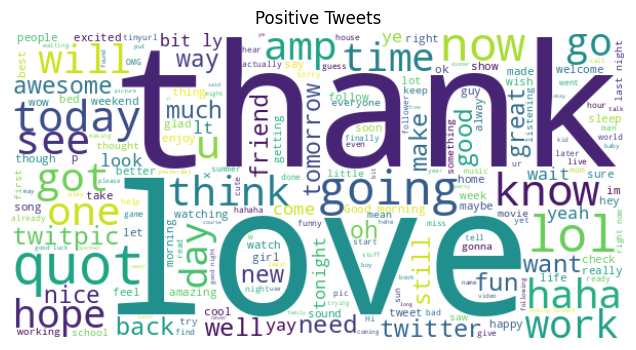

In [ ]:
# C) WordClouds
for val,label in [(0,'Negative Tweets'),(1,'Positive Tweets')]:
    text = ' '.join(df[df.sentiment==val]['clean_text'])
    wc = WordCloud(width=600, height=300, background_color='white').generate(text)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.title(label); plt.axis('off'); plt.show()

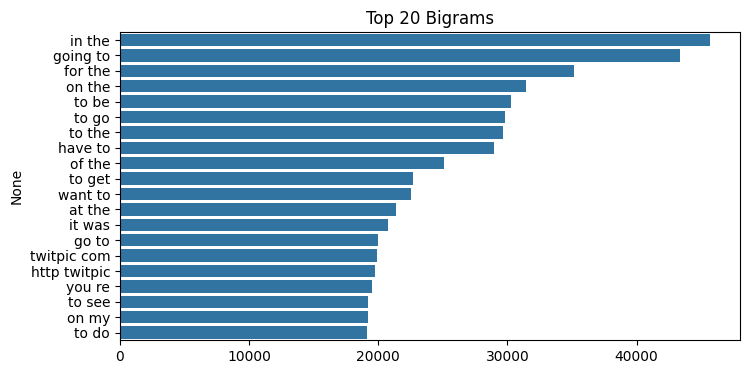

In [ ]:
# D) Top bi-grams
cvb = CountVectorizer(ngram_range=(2,2), max_features=20)
X2 = cvb.fit_transform(df['clean_text'])
bi_counts = pd.DataFrame(X2.toarray(), columns=cvb.get_feature_names_out()).sum().sort_values(ascending=False)
plt.figure(figsize=(8,4))
sns.barplot(x=bi_counts.values, y=bi_counts.index)
plt.title('Top 20 Bigrams'); plt.show()

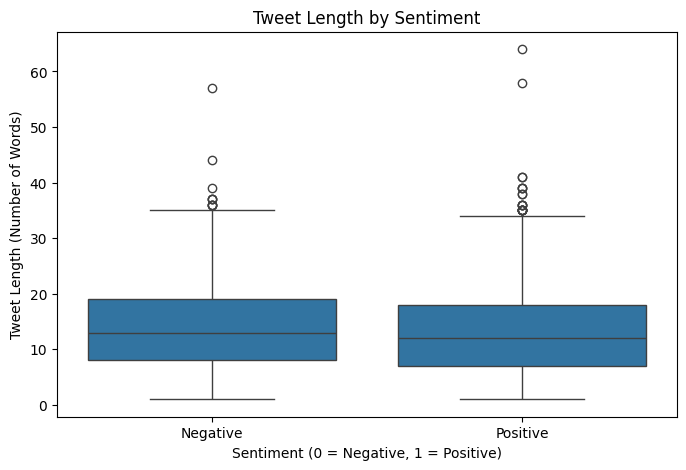

In [ ]:
plt.figure(figsize=(8,5))
sns.boxplot(x='sentiment', y='length', data=df)
plt.title('Tweet Length by Sentiment')
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Tweet Length (Number of Words)')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()


<ipython-input-35-5044ebc855b7>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(pos_words.values()), y=list(pos_words.keys()), ax=axes[0], palette='Greens_d')
<ipython-input-35-5044ebc855b7>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(neg_words.values()), y=list(neg_words.keys()), ax=axes[1], palette='Reds_d')


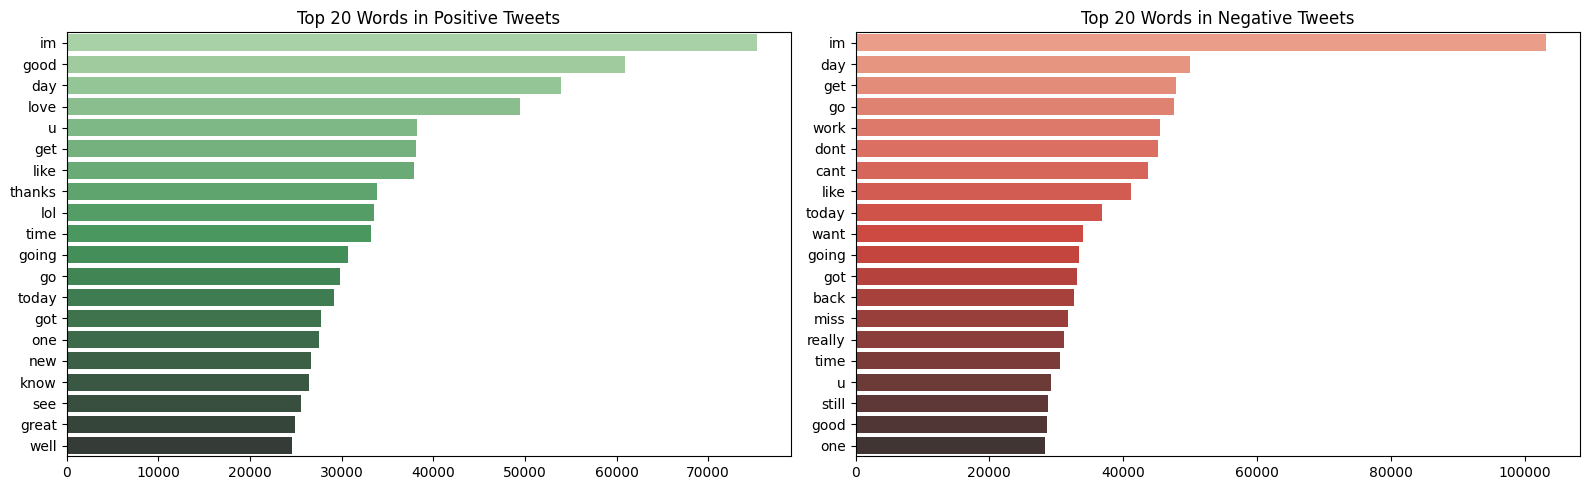

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt # Import matplotlib
import seaborn as sns # Import seaborn

def top_words(corpus, n=20):
    all_words = ' '.join(corpus).split()
    return dict(Counter(all_words).most_common(n))

# Get top 20 words for each sentiment
pos_words = top_words(df[df.sentiment == 1]['clean'])
neg_words = top_words(df[df.sentiment == 0]['clean'])

# Plot side-by-side bar charts
fig, axes = plt.subplots(1, 2, figsize=(16,5))
sns.barplot(x=list(pos_words.values()), y=list(pos_words.keys()), ax=axes[0], palette='Greens_d')
axes[0].set_title('Top 20 Words in Positive Tweets')

sns.barplot(x=list(neg_words.values()), y=list(neg_words.keys()), ax=axes[1], palette='Reds_d')
axes[1].set_title('Top 20 Words in Negative Tweets')

plt.tight_layout()
plt.show()

In [ ]:
# Text preprocessing
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download necessary NLTK data
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(txt):
    """Clean and preprocess text"""
    txt = re.sub(r'http\S+|@\w+|[^a-zA-Z\s]', '', txt)
    txt = txt.lower().split()
    txt = [lemmatizer.lemmatize(w) for w in txt if w not in stop_words]
    return ' '.join(txt)

# Apply cleaning - ready for Word2Vec or other vectorization methods
df['clean'] = df['clean_text'].apply(clean_text)

Experiment Tables

In [ ]:
# LR hyperparameter grid
vectorizers = {
    'TF-IDF': TfidfVectorizer(max_df=0.9, min_df=5),
    'Count': CountVectorizer(max_df=0.9, min_df=5)
}
params = {'C': [0.1, 1.0, 10]}
results_lr = []
X, y = df['clean'], df['sentiment']
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=42)

for name, vec in vectorizers.items():
    X_tr_vec = vec.fit_transform(X_tr)
    X_te_vec = vec.transform(X_te)
    grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=params, cv=3)
    grid.fit(X_tr_vec, y_tr)
    results_lr.append({
        'Vectorizer': name,
        'Best C': grid.best_params_['C'],
        'Test Acc': grid.score(X_te_vec, y_te)
    })
df_lr_exp = pd.DataFrame(results_lr)
display(df_lr_exp)


,Vectorizer,Best C,Test Acc
0,TF-IDF,1.0,0.781312
1,Count,1.0,0.780119


In [ ]:
# LSTM hyperparameter grid
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(df['clean'])
seqs = tokenizer.texts_to_sequences(df['clean'])
X_seq = pad_sequences(seqs, maxlen=100)
y_seq = df['sentiment'].values
X_tr2, X_te2, y_tr2, y_te2 = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

lstm_results = []
for batch in [32, 64]:
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128, input_shape=(100,)),
        LSTM(64),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    hist = model.fit(X_tr2, y_tr2, epochs=3, batch_size=batch, validation_split=0.1, verbose=0)
    lstm_results.append({'Batch Size': batch, 'Val Accuracy': hist.history['val_accuracy'][-1]})
df_lstm_exp = pd.DataFrame(lstm_results)
display(df_lstm_exp)


In [ ]:
# Logistic Regression Model Evaluation
tfidf = TfidfVectorizer(max_df=0.9, min_df=5)
X_train, X_test, y_train, y_test = train_test_split(df['clean'], df['sentiment'], test_size=0.2, random_state=42)
X_tr_tfidf = tfidf.fit_transform(X_train)
X_te_tfidf = tfidf.transform(X_test)

lr = LogisticRegression(C=1.0, max_iter=1000)
lr.fit(X_tr_tfidf, y_train)
y_pred_lr = lr.predict(X_te_tfidf)

print("Logistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))


In [ ]:
# Confusion Metrix and ROC for LR
cm = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('LR Confusion Matrix'); plt.ylabel('Actual'); plt.xlabel('Predicted'); plt.show()

y_score_lr = lr.predict_proba(X_te_tfidf)[:,1]
fpr, tpr, _ = roc_curve(y_test, y_score_lr)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}'); plt.plot([0,1],[0,1],'k--')
plt.title('LR ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()


In [ ]:
# LSTM Model Full Build
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_shape=(100,)),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

history = model.fit(X_tr2, y_tr2, epochs=5, batch_size=64, validation_data=(X_te2, y_te2))


In [ ]:
# EVALUATE LSTM + CM & ROC
y_prob = model.predict(X_te2).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("LSTM Classification Report:\n", classification_report(y_te2, y_pred))
print("Accuracy:", accuracy_score(y_te2, y_pred))

cm2 = confusion_matrix(y_te2, y_pred)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Reds')
plt.title('LSTM Confusion Matrix'); plt.show()

fpr2, tpr2, _ = roc_curve(y_te2, y_prob)
roc_auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, label=f'AUC = {roc_auc2:.2f}'); plt.plot([0,1],[0,1],'k--')
plt.title('LSTM ROC Curve'); plt.xlabel('FPR'); plt.ylabel('TPR'); plt.legend(); plt.show()


### Sample Predictions with Logistic Regression


In [ ]:
# Sample predictions using Logistic Regression
sample_tweets = [
    "This is a great movie!",
    "I am very disappointed with the service.",
    "The weather is nice today.",
    "What a terrible experience."
]

# Preprocess the sample tweets using the same steps as the training data
cleaned_tweets = [clean_text(tweet) for tweet in sample_tweets]
sample_tweets_tfidf = tfidf.transform(cleaned_tweets)

# Predict sentiment
lr_predictions = lr.predict(sample_tweets_tfidf)

# Display predictions
print("Logistic Regression Predictions:")
for tweet, prediction in zip(sample_tweets, lr_predictions):
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Tweet: '{tweet}' -> Predicted Sentiment: {sentiment}")

### Sample Predictions with LSTM


In [ ]:
# Sample predictions using LSTM
# Preprocess the sample tweets for LSTM
cleaned_tweets = [clean_text(tweet) for tweet in sample_tweets]
sample_seqs = tokenizer.texts_to_sequences(cleaned_tweets)
sample_padded_seqs = pad_sequences(sample_seqs, maxlen=100)

# Predict sentiment probabilities
lstm_probabilities = model.predict(sample_padded_seqs).ravel()

# Convert probabilities to sentiment labels
lstm_predictions = (lstm_probabilities > 0.5).astype(int)

# Display predictions
print("\nLSTM Predictions:")
for tweet, prediction, prob in zip(sample_tweets, lstm_predictions, lstm_probabilities):
    sentiment = "Positive" if prediction == 1 else "Negative"
    print(f"Tweet: '{tweet}' -> Predicted Sentiment: {sentiment} (Probability: {prob:.4f})")